In [59]:
#Importing the packages needed for this analysis
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer


%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi']= 400

In [60]:
import json
from pymongo import MongoClient

client = MongoClient()
"""db = client.legislation
tweets = db.news"""

'db = client.legislation\ntweets = db.news'

In [61]:
tastingflavors = {'Spicy':['cocoa','clove', 'vanilla','pepper', 'saffron','nutmeg','licorice','menthol','cinnamon'],\
'Char':['ash','tar','toast','wood smoke','tobacco','fireplace','burnt food','grilled food'],\
'Sweet':['malt','brown sugar','candy','honey','caramel','molasses','burnt sugar','maple syrup','sweet'],\
'Nutty':['almond', 'peanut','walnut','chestnut','hazelnut', 'roasted nuts'],\
'Floral':['rose','hops','orchid','violet','jasmine','perfume','geranium','dandelion','honeysuckle','lily of the valley','orange blossom'],\
'Herbs':['thyme','parsley','cardamom','eucalyptus','fennel seed','coriander'],\
'Vegetables':['spinach','broccoli','zucchini','asparagus','garden peas','green pepper','squash blossom'],\
'Grass':['stems','straw','barnyard','grapeseed','fresh cut grass','grass'],\
'Wood':['evergreen','bark','cedar','resin','freshly cut wood','sawdust','wet wood','driftwood','green wood','cherry wood'],\
'Earth':['peat','moss','musty','leather','compost','wet earth','forest floor','decaying wood'],\
'Mineral':['salt', 'metalllic', 'wet rocks'],\
'Marine':['seawood','ocean air'],\
'Berry':['raspberry','strawberry','blackberry', 'black currant'],\
'Citrus':['lemon','orange','grapefruit','citrus zest'],\
'Tree Fruit':['peach','pear','apricot','apple','cooked fruit','dried fruit'],\
'Tropical':['mango','melon','lychee', 'banana','pineapple'],
'Malolactic':['butter']}

wheel = {'Earthy':['Wood','Earth','Mineral','Marine'],'Vegetal':['Grass','Vegetables','Herbs'],\
         'Fruity':['Berry','Citrus','Tree Fruit','Tropical']}


In [62]:
#reading a pickle file reading to pick up where i left off in case something fails or i start over
with open("tea_data.pkl", 'rb') as picklefile: 
    teareview_dict = pickle.load(picklefile)

In [63]:
reviewcount = []
count =0
for i in teareview_dict:
    count=0
    for j in teareview_dict[i]: 
        count+=len(j['Tea Reviews'])
    reviewcount.append(count)


In [64]:
sum(reviewcount)


6931

## More Data Wrangling

Now that I have the dataframe imported, I am going to use NLP to work with the different reviews on certain teas to create more insights and set it up for unsupervised learning.

### Tasting Considerations
* Aroma: The odor of the tea liquor, also called the nose or fragrance. A complex aroma is often described as a bouquet. 
* Astringency: A lively and mouth-drying effect on the tongue. Not bitter, but a clean and refreshing quality. The sensation of astringency is caused by a reaction between polyphenols (tannins) and the protein in saliva. 
* Body: The tactile aspect of tea’s weight and substance in the mouth, variously subcategorized as light, medium, or full; also known as fullness. 
* Bright: A lively, clean style that refreshes the palate. 
* Character: A tea’s signature attributes depending upon origin, whether of its country, region or type. 
* Clean: Indicates purity of flavor and an absence of any off-tastes. 
* Finish: The lasting taste on your tongue after swallowing the tea. 
* Flowery: A floral nose or flavor associated with high grade teas. 
* Full: References a positive sensation of body and good heft; indicates a well-made tea, possessing color, strength, substance and roundness. 
* Malty: A sweet malt flavor that is characteristic of Assam black teas. 
* Muscatel: A flavor reminiscent of grapes, most often used to describe an exceptional characteristic found in the liquors of the finest Darjeelings. 
* Smooth: Round-bodied, fine-drinking teas. 
* Soft: Smooth, lush, and subsequently often (but not necessarily) timid in flavor; not a negative term. 
* Thick: Describes liquor having substance, but not necessarily strength. 
* Vegetal: A characteristic of green teas that might include grassy, herby or marine flavors.

In [37]:
import nltk
import re


In [38]:
teareview_dict['Green Tea'][0].keys()

dict_keys(['Tea Name', 'Tea Ingredients', 'Tea Flavors', 'Tea Reviews'])

### Polarity Score
Using TextBlob, I will be creating a polarity score for each review.  This is to help weight the reviews if needed. 

In [39]:
polarityscore = []
for i in teareview_dict:
    for j in teareview_dict[i]: 
        for review in j['Tea Reviews']:
            q = TextBlob(review)
            polarityscore.append(q.sentiment.polarity)
        j['Polarity']=polarityscore
        polarityscore=[]

In [40]:
teareview_dict['Black Tea'][0]['Polarity']

[0.24780701754385964,
 0.215,
 0.22731829573934836,
 0.12239389776889774,
 0.3666666666666667,
 0.32083333333333336,
 0.012499999999999999,
 0.14273268398268396,
 0.13819444444444445,
 0.2731600935828877]

### Proportion Flavor Wheel and Mouthfeel

Using the flavor wheel found online, I will create a flavor profile for each tea. I will need to use 1 and 2 n-grams and the tastingflavors dictionary.

I also want to get any 'mouthfeel' data to see what added bonus it could give to the tea. 

In [41]:
playlist = teareview_dict['Black Tea'][0]['Tea Reviews']

In [42]:
#Combining all reviews into a long string text to make it easier to pull out stop words.
#Also pulling out sentences with 'mouthfeel' to find adj for another feature.
supertext=""
mouthfeel = ''
for i in playlist:
    supertext += (' '+ i)
    if re.findall(r"([^[.!]]*?mouthfeel[^.]*\.)",i):
        print(re.findall(r"([^.!,]*?mouthfeel[^.!,]*\.)",i))
        mouthfeel=' '.join((re.findall(r"([^.!,]*?mouthfeel[^.!,]*\.)",i)))

supertext = re.sub("[’,;:–…]","", supertext).replace("(", '').replace(".", ' ').replace("!", ' ').replace(")", '')
supertext= re.sub("(-)"," ", supertext)
supertext= re.sub("(chocolate)","cocoa", supertext)

['  A very rich cup yet the mouthfeel is bright and cheery.', '  As the tea cools a bit it does become slightly thicker with a heavier mouthfeel and notes of maple syrup begin to peek through.']


In [43]:
mouthblob = TextBlob(mouthfeel)
mouthadj = []
for i in mouthblob.tags:
    if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS':
        mouthadj.append(i[0])

In [52]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
 
stop_words = stopwords.words('english')
stop_words = stop_words + ['the','i','I','a','of',')','\'', 'to', 'it','and','is','this','for', 'but', 'that', 'in', 'my', 'not','husband',\
            'be', 'we', 'are', 'm', 'as', 'just', 'there', 'you','all','with','me', 'few', 'will', 'on','has', 'was','many','last'\
              '''()''', "'",'!','.','It',',', '-',':','Thanksgiving','Im','youll','Ive','Its','Also','A','As','This','cant','anybody',\
               'go','one','everybody','dont', 'We', 'us', 'got', 'And']

word_tokens = word_tokenize(supertext)
sentence = ''

filtered_sentence = [w for w in word_tokens if not w in stop_words]
for i in filtered_sentence:
    sentence += (' '+i)

In [54]:
adjlist = []
for i in text1.tags:
    if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS' or i[1]=='NN'or i[1]=='NNS':
        abb = re.sub("y","", i[0])
        if(i[0] !=abb):
            adjlist.append(abb)
            adjlist.append(i[0])
        else:
            adjlist.append(i[0])

In [56]:
#creating flavor profile based on the tastingflavors dict, stored as proportions
def getProp(text1):
    text1=TextBlob(text1)
    count=0
    tot_count=0
    proportion_dict = {}
    adjlist=[]
    for i in tastingflavors:
        count=0
        for j in text1.tags:
            if j[1]=='JJ' or j[1]=='JJR'or j[1]=='JJS' or j[1]=='NN'or j[1]=='NNP'or j[1]=='NNS':
                abb = re.sub("y","", i[0])
                if(i[0] !=abb):
                    adjlist.append(abb.lower())
                    adjlist.append(j[0].lower())
                else:
                    adjlist.append(j[0].lower())
        for k in adjlist:
            if k in tastingflavors[i]:
                count+=1
        for k in text1.ngrams(n=2):
            if ' '.join(k.lower()) in tastingflavors[i]:
                count+=1
        tot_count+=count
        proportion_dict[i]=count
    if tot_count!=0:
        for i in proportion_dict:
            proportion_dict[i] = proportion_dict[i]/tot_count
        
    return proportion_dict

In [57]:
#function pulling out mouthfeel data and filtering out unnecessary data
def getReviews(revlist):
    supertext=""
    mouthfeel = ''
    for i in revlist:
        supertext += (' '+ i)
        if re.findall(r"([^[.!]]*?mouthfeel[^.]*\.)",i):
            mouthfeel=' '.join((re.findall(r"([^.!,]*?mouthfeel[^.!,]*\.)",i)))

    supertext = re.sub("[’,;:–…]","", supertext).replace("(", '').replace(".", ' ').replace("!", ' ').replace(")", '')
    supertext= re.sub("(-)"," ", supertext)
    supertext= re.sub("(chocolate)","cocoa", supertext)
    word_tokens = word_tokenize(supertext)
    sentence = ''
    mouthblob = TextBlob(mouthfeel)
    mouthadj = []
    for i in mouthblob.tags:
        if i[1]=='JJ' or i[1]=='JJR'or i[1]=='JJS':
            mouthadj.append(i[0])
    
    
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for i in filtered_sentence:
        sentence += (' '+i)
    return supertext, mouthadj

In [58]:
#creating a flavor profile from both reviews and flavors filled in by customers, also makign a mouthfeel profile if found
newdictlist = []
for i in teareview_dict:
    newdictlist = []
    for j in range(len(teareview_dict[i])):
        flavtext = ''
        reviewtext, mouthfeel= getReviews(teareview_dict[i][j]['Tea Reviews'])
        proportions = getProp(reviewtext)
        if teareview_dict[i][j]['Tea Flavors']:
            flavtext = teareview_dict[i][j]['Tea Flavors']
        custproportions= getProp(flavtext)
        dict2 = teareview_dict[i][j].copy()
        dict2['Mouthfeel']=mouthfeel
        dict2['Flavor Profile Cust']=custproportions
        dict2['Flavor Profile Reviews']=proportions
        dict2['Reviews Supertext']=reviewtext
        newdictlist.append(dict2)
    teareview_dict[i] = newdictlist

In [59]:
with open('totstea_data.pkl', 'wb') as picklefile:
    pickle.dump(teareview_dict, picklefile)

In [60]:
from pprint import pprint
for i in teareview_dict['Green Tea']:
    pprint(i)

{'Flavor Profile Cust': {'Berry': 0.0,
                         'Char': 0.0,
                         'Citrus': 0.0,
                         'Earth': 0.05263157894736842,
                         'Floral': 0.0,
                         'Grass': 0.0,
                         'Herbs': 0.0,
                         'Malolactic': 0.8947368421052632,
                         'Marine': 0.0,
                         'Mineral': 0.0,
                         'Nutty': 0.0,
                         'Spicy': 0.05263157894736842,
                         'Sweet': 0.0,
                         'Tree Fruit': 0.0,
                         'Tropical': 0.0,
                         'Vegetables': 0.0,
                         'Wood': 0.0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.057971014492753624,
                            'Citrus': 0.0,
                            'Earth': 0.014492753623188406,
                            'Floral': 0.14492753623188406,
       

                 'and fresh on the tongue. It has the usual taste elements of '
                 'a good-quality fuka as well. Excellent, but pricey.First '
                 'infusion – 3 g. per 8 oz water, 65 deg., 3:00 min.Second '
                 'infusion – 3 g. per 8 oz. water, 65 deg., 10:00+ min.',
                 'As always, I love Mellow Monk. This tea is delicious! It has '
                 'a stronger, more refined flavor than the Top Leaf. It’s more '
                 'vegetal, and has mild berry notes, which I love. It’s '
                 'buttery, and has a creamy texture. The color is a beautiful, '
                 'and deep shade of green. I would definately order more of '
                 'it, and keep it for those special times.::Edit:: I just '
                 'decided to try this in my gaiwan, instead of my kyusu, and '
                 'wow! If I’d known that tea could taste this good, I would’ve '
                 'been living off the stuff! I had to bump th

                      'target="_blank">https//instagram '
                      'com/p/1wcWpRwh33/</a><a href="https//instagram '
                      'com/p/1wdSdSQh5K/" rel="nofollow" '
                      'target="_blank">https//instagram '
                      'com/p/1wdSdSQh5K/</a><a href="https//instagram '
                      'com/p/1weEizQh6H/" rel="nofollow" '
                      'target="_blank">https//instagram com/p/1weEizQh6H/</a>',
 'Tea Flavors': 'Asparagus, Butter, Chestnut, Grass, Hay, Honey, Lettuce, '
                'Malt, Mineral, Pine, Seaweed, Smoke, Umami, Zucchini, '
                'Artichoke, Floral, Green, Kale, Nectar, Nutty, Smooth',
 'Tea Ingredients': 'Green Tea',
 'Tea Name': 'High Mountain Xinyang Maojian',
 'Tea Reviews': ['This was yet another back-of-the-tea cabinet discovery. I '
                 'knew I had bought an ounce of this last year, but '
                 'apparently, I had forgotten about it entirely. It was all '
               

                      'on the package  it says “Mental Focus”  I soooo needed '
                      'that today My dear Sororitea Sister LiberTeas will tell '
                      'yaIve had a flighty morning and technology hasnt been '
                      'my friend  LOLAnyhowthis SHOULD help me get back on '
                      'track  I HOPE This is really good matcha  Its velvety '
                      'and pleasant from start to finish  ANDit stays mixed '
                      'the whole cuppa  It froths up and stays mixed well '
                      'throughout with little to no chalky end cup  YAY  Today '
                      'I tried out the Ceremonial Grade Matcha from Aiya '
                      'hopefully tomorrow I will get to the Organic Ceremonial '
                      'Grade  Here are my thoughtsWhile whisking this one it '
                      'was evident how different it was from the Premium Grade '
                      'Matcha  It was thicker  VERY f

                      'buttered green vegetables but the “buttery” sensation '
                      'soon dissipates and shifts to a sweet vegetal sort of '
                      'flavor  Grassy but not bitter  Brothy  Savory and sweet '
                      'at the same time — how does it manage that? The flavors '
                      'are really strong and keep shifting from vegetal and '
                      'grassy to sweet and almost herbal and the flavors are '
                      'long lasting I can still taste this tea in a good way '
                      'several minutes after drinking it  Its delicious like '
                      'springtime in a cup The first time I brewed this I let '
                      'it sit for just one minute too long and it came out a '
                      'tad astringent so I would say this is a tea that is '
                      'indeed fussy about brew times  But if you follow the '
                      'directions on the package yo

                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.2225,
              0.22337962962962962,
              0.31986394557823133,
              0.6,
              0.30833333333333335,
              0.10520833333333333,
              1.0,
              0.6071428571428571,
              0.6083333333333333],
 'Reviews Supertext': ' Ever since seeing the excellent documentary “All In '
                      'This Tea” Ive wanted to try this one and I finally got '
                      'the chance when a local Chinese friend of mine brought '
                      'some in to my shoppe for blending  During the '
                      'aforementioned documentary film renown tea master '
                      'Gaetano Kazuo Maida does a public tasting of this '
                      'specfic tea and describes the experience as “vegetal '
                      'without being flowery earthy seaweed ” Well hes got a '
        

                         'Malolactic': 0,
                         'Marine': 0,
                         'Mineral': 0,
                         'Nutty': 0,
                         'Spicy': 0,
                         'Sweet': 0,
                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.7692307692307693,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.23076923076923078,
                       

                         'Nutty': 0,
                         'Spicy': 0,
                         'Sweet': 0,
                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.5,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.1875,
                            'Tree Fruit': 0.3125,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            

                      'cant wait to try more flavors from Red Leaf  I have a '
                      'traditional matcha set with plain matcha on its way and '
                      'I am now even more eager to try  Somehow I am going to '
                      'have to fit drinking this caramel goodness in daily  I '
                      'actually feel more energetic and high spirited and I am '
                      'attributing to the matchaccino  You can get this '
                      'scrumptious caramel Matchaccino at Red Leaf Tea here <a '
                      'href="http//www redleaftea com/matchaccino/caramel '
                      'matchaccino html" rel="nofollow" '
                      'target="_blank">http//www redleaftea '
                      'com/matchaccino/caramel matchaccino html</a>Also my '
                      'boyfriends response was “I could drink this  Much '
                      'better than all these other girl teas you have been '
                   

                            'Tree Fruit': 0.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.12333333333333334,
              0.08446969696969697,
              0.21959905660377357,
              -0.0009999999999999942,
              0.2566666666666666,
              0.47980769230769227,
              0.22600694444444447,
              0.206781045751634,
              0.3859375,
              0.05],
 'Reviews Supertext': ' I havent had this one in a while so I made a pot of '
                      'it  It was very refreshing since Ive had a lot of '
                      'flavored teas recently  The subtle flavor of pine is '
                      'just lovely with the buttery green tea  Pretty sure my '
                      'feed isnt working here but oh well This was a sad '
                      '<strong>sipdown</strong> but I appreciated the chance '
          

                      'com/s/ref=nb_sb_noss?url=search alias%3Daps&ampfield '
                      'keywords=japanese+tea+doll+canister&ampx=0&ampy=0" '
                      'rel="nofollow" target="_blank">http//www amazon '
                      'com/s/ref=nb_sb_noss?url=search alias%3Daps&ampfield '
                      'keywords=japanese+tea+doll+canister&ampx=0&ampy=0</a> '
                      'and this one<a href="http//www amazon com/White Hakata '
                      'Doll Canister '
                      'Japan/dp/B004AMBMUQ/ref=sr_1_fkmr2_1?ie=UTF8&ampqid=1297976451&ampsr=8 '
                      '1 fkmr2" rel="nofollow" target="_blank">http//www '
                      'amazon com/White Hakata Doll Canister '
                      'Japan/dp/B004AMBMUQ/ref=sr_1_fkmr2_1?ie=UTF8&ampqid=1297976451&ampsr=8 '
                      '1 fkmr2</a> And I just ordered the sakura sencha from '
                      'Dens tea  I am so very anxious to try some  Their '
             

                      'this?? There was such a smoothness on my palate but '
                      'after I swallowed the tea <strong>POP   BANG   POW  '
                      '</strong> The tea recharged on my palate with a mild '
                      'tartness  That was another first for me &amp nothing '
                      'short of AMAZING  My second cup [7 minutes at 212F '
                      'showcased a lemony tart aroma between 4 5 minutes  One '
                      'cone was still clinging together so I broke the leaves '
                      'apart hoping to achieve more aroma and flavor  There '
                      'was deeper tart lemon and artichoke aromas with some '
                      'sweetness  Wet leaves also gave deeper aromas of lemon '
                      'artichoke dill and woods  The longer steep brought out '
                      'light smokey notes as well While still quite light the '
                      'cup turned a deeper yellow  Slightl

                         'Spicy': 0,
                         'Sweet': 0,
                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0,
                            'Char': 0,
                            'Citrus': 0,
                            'Earth': 0,
                            'Floral': 0,
                            'Grass': 0,
                            'Herbs': 0,
                            'Malolactic': 0,
                            'Marine': 0,
                            'Mineral': 0,
                            'Nutty': 0,
                            'Spicy': 0,
                            'Sweet': 0,
                            'Tree Fruit': 0,
                            'Tropical': 0,
                            'Vegetables': 0,
                            'Wood': 0},
 'Mouthfeel': [],
 'Polarity': [0.5857142857142856],
 'Reviews 

                      'target="_blank">http//sororiteasisters '
                      'com/2014/04/21/organic nonpareil qian dragon well long '
                      'jing green tea teavivre/</a> Thank you so much for '
                      'being so generous Teavivre  Wow  I always appreciate it '
                      'so much  It really makes my day or week to receive a '
                      'package of teas all the way from China  A sample '
                      'package just in time for triple review points  I '
                      'promised Id try this one as soon as I got it because I '
                      'insisted they wait to send it with the other teas they '
                      'wanted to send  As fresh as possible  Hopefully it '
                      'didnt affect the teas too much sitting in the 95 degree '
                      'mailbox for an hour before I rescued them and probably '
                      'warmer because it is a brown mailbox  The dry leaves 

                      'its still perfectly drinkable just different It has '
                      'such a unique pure flavor that Im struggling to '
                      'describe it with any words other than “Strong '
                      'Dragonwell ”Dragonwell is my favorite kind of green tea '
                      'though  I havent been drinking looseleaf for very long '
                      'so most of my teas have been come and go  Dragonwell '
                      'Teavana variety is the only one Ive repurchased over '
                      'and over I trained a girl at work today because Im '
                      'apparently the star cashier  Its not because Im '
                      'particularly good at my job Ive just been there longer '
                      'and I actually <em>do</em> my job as opposed to some of '
                      'the boys / high school kids who just kind of stand up '
                      'there and text the whole time  Training is lovely 

                 'like green tea as much as others!).\n'
                 '\n'
                 '<p class="flavor-names">Flavors: Plants\n'
                 '</div>, <div class="text">\n',
                 'Green. Vegetable. Creamy. Ehhh sorry, not for me, '
                 '<strong>Albertocanfly</strong>! :(',
                 'Thank you to <strong>Bonnie</strong> for sending me this '
                 'tea. It has languished in the cupboard until today when I '
                 'found it tucked at the back. The leaf is dark green and '
                 'twisty. It brews up to an olive green leaf and a pale soup. '
                 'The colours are great and the aroma of the liquor is green '
                 'beans and spinach. The aroma carries into the tea with '
                 'vegetal notes, green beans and a touch of spinach. It is '
                 'creamy and quite filling. Thank you, Bonnie. This is a good '
                 'green tea and quite different from most that I

                 'one out this afternoon, though I am a little wired already '
                 'from having some gyokuro matcha with lunch. I followed the '
                 'MM instructions which said to steep for 2 minutes @ 170F — I '
                 'guesstimated.There’s a TON of dried yuzu peel in this '
                 'package. My cup ended up being a light yellow so I was '
                 'somewhat worried about the flavor, but it’s delightful, IMO. '
                 'The yuzu lends a grapfruity/lemon note and I am definitely '
                 'picking up on the rose element. It’s got a lightly sweet and '
                 'tart flavor and the green tea is just lending a slightly '
                 'vegetal quality with a hint of berry. Hmm. This is good, I '
                 'like it! Very refreshing for the afternoon. I bet this would '
                 'also be good iced or mixed with some sparkling water as an '
                 'apertif.',
                 'Oh my! T

                 'Laoshan Black.I can’t wait to try the Autumn Harvest Laoshan '
                 'Dragonwell Style Laoshan Green with her and see if she can '
                 'pick out the cherry notes in Mrs. Li’s Dragonwell. We both '
                 'got glass tumblers with flat strainers at the top for '
                 'Christmas so we can sip together all day. Unfortunately the '
                 'Zojirushi is not going to work out for her and I need to '
                 'find another variable temperature kettle that has a 170-175 '
                 'setting, will hold that temperature but does not '
                 'automatically bring the water up to a boil first. But that’s '
                 'more for the forums.',
                 'As noted by Terri this version does not look like the '
                 'picture. It is flat rolled into long dark brittle twists. '
                 'This tea does some funky stuff. First off, I don’t know why '
                 'one steep

{'Flavor Profile Cust': {'Berry': 0.0,
                         'Char': 0.0,
                         'Citrus': 0.0,
                         'Earth': 0.0,
                         'Floral': 0.0,
                         'Grass': 0.0,
                         'Herbs': 0.0,
                         'Malolactic': 0.0,
                         'Marine': 0.0,
                         'Mineral': 0.0,
                         'Nutty': 0.0,
                         'Spicy': 0.0,
                         'Sweet': 0.0,
                         'Tree Fruit': 0.0,
                         'Tropical': 0.0,
                         'Vegetables': 1.0,
                         'Wood': 0.0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.6451612903225806,
                            'Herbs': 0.0,
     

                 'enough to recommend one over the other. The first steep had '
                 'a floral and vaguely fruity taste and a nice aroma. After '
                 'the first steep I had to run out and do errands, so I left '
                 'it in the strainer to hang out until I returned. Upon '
                 'steeping it again, the tea had the strangest taste, jasmine '
                 'at first and then resin and pine needles. Whaaaaaaaat?A '
                 'picture of Butterfly Jasmine hanging out in my new mug: <a '
                 'href="http://instagr.am/p/SgqguXykX9/" rel="nofollow" '
                 'target="_blank">http://instagr.am/p/SgqguXykX9/</a>',
                 'Jasmine-scented green tea is the crutch by which I hobble '
                 'through winter. My daily poison is Jasmine Pearls or Dragon '
                 'Tears, and so all Jasmine-scented green teas are rated by '
                 'how well they compare to that standard.Jasmine Butterf

                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.0,
                            'Tree Fruit': 1.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': ['full', 'fantastic', 'doesn'],
 'Polarity': [0.4020833333333334, 0.23030303030303034, 1.0, 0.170018315018315],
 'Reviews Supertext': ' Dragonwell is probably my favorite tea to drink and '
                      'this one from Red Blossom Tea is delicious  The dry '
                      'le

 'Tea Reviews': ['Another tea from the Here’s Hoping TTB. It’s been awhile '
                 'since I had a Gyokuro. I do enjoy them. It’s a very pale '
                 'infusion, a very sweet spring green color. The tea is like a '
                 'thin Matcha, very green &amp; delicious.',
                 'Somewhat sweet but still brothy, too! This is very '
                 'delicious! I’ve noticed it can get grassier tasting if '
                 'infused for longer than a minute. On the other hand 2nd '
                 'infusions and possible 3rd infusions are somewhat '
                 'lemony…which I enjoyed, too! A versatile cuppa. Yum!',
                 'Sipdown (120)! I used up the last of this leaf in a cold '
                 'brew since I don’t really drink too much hot tea these days. '
                 'I left it in the fridge for about 9-10 hours, which in '
                 'hindsight was probably too long because there was a bit of '
                 'bitternes

                 'infusion was probably my favorite, highlighting the buttery '
                 'taste I can’t get enough of. The third was like the second, '
                 'but less potent.Steeping notes: 3oz. with 2 g 1. 145* at 90 '
                 'sec. 2. 160* at 60 sec. 3. 170* at 90 sec.',
                 'I usually choose a strong black tea for my morning cup, but '
                 'we were out of town all weekend and don’t have any milk in '
                 'the fridge, so I’m happily settling with this green tea '
                 'instead. It gives me a chance to get to some of my green tea '
                 'samples, like this one is from Mercuryhime. The dry leaves '
                 'smell slightly sweet and grassy. The tea itself has a '
                 'vegetal aroma. I usually tend to choose flavored green teas, '
                 'so this one was bit of a surprise to me. It has a fresh '
                 'seaweed flavor with a sweet finish. There is a a stro

 'Tea Ingredients': 'Not available',
 'Tea Name': 'Chiran Sencha',
 'Tea Reviews': ['An excellent first infusion followed by a very pleasant '
                 'second make this a great tea. The third infusion is nothing '
                 'special, but third infusions rarely are for me in the world '
                 'of senchas.First infusion — 5 g. per 8 oz. water, 60 deg., 1 '
                 'min.Second infusion — 5 g. per 8 oz. water, 60 deg., 1 '
                 'min.Third infusion — 5 g. per 8 oz. water, 60 deg., 5+ min.',
                 'O-Cha’s Chiran Sencha (which I’m drinking here in Shincha '
                 'form) is a deep steamed Fukamushi tea that’s made of fresh '
                 'leaves from the Yutaka Midori bush. It’s an easy brewer that '
                 'tastes great extra-strong, but for this review I did a '
                 '“proper” brew of 4g to 4oz water in my tiny Banko '
                 'houhin.First (155*/ 90 secs): Bold aroma — I just love how '

                 'any sense. And I might very well be imagining this but it '
                 'also seems fruit-y, red berry-ish, to me.Really lovely tea\n'
                 '\n'
                 '<p class="flavor-names">Flavors: Menthol, Violet\n'
                 '</div>, <div class="text">\n',
                 'This tea is my first Mariage et Frères. The odour was not '
                 'convincing but I’m appreciating the deepnss of the violet '
                 'taste.']}
{'Flavor Profile Cust': {'Berry': 0.0,
                         'Char': 0.0,
                         'Citrus': 0.0,
                         'Earth': 0.0,
                         'Floral': 0.0,
                         'Grass': 1.0,
                         'Herbs': 0.0,
                         'Malolactic': 0.0,
                         'Marine': 0.0,
                         'Mineral': 0.0,
                         'Nutty': 0.0,
                         'Spicy': 0.0,
                         'Sweet': 0.0,
 

                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.0,
                            'Tree Fruit': 1.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.07897816469245042,
              0.4357142857142858,
              0.23696428571428568,
              0.26988095238095233,
              0.01491228070175438],
 'Reviews Supertext': ' Im craving this again  It is my favorite from the new '
                      'Zodiac series  For me it has the right balance of '
                      'green/white tea + the faint taste of apples and mint  I '
                      'truly enjoy this Ive decided not to rate teas anymore  '
                      'When I drink tea I like to go with the flow just '
                      'experiencing the taste and smell without devising some '
                      '“object

                      'expensive $22 for 50g  If price isnt an issue for you '
                      'Id highly recommend checking this out even if you dont '
                      'normally like green tea  I just got this in the order '
                      'this week and Im drinking it for the first time right '
                      'now  Im logging it in but I dont have time for a proper '
                      'review  All I can say at this point that its a divine '
                      'tea  I love it ',
 'Tea Flavors': 'Butter, Spinach, Vegetable Broth, Floral, Forest Floor, '
                'Green, Ocean Air, Ocean Breeze, Seaweed, Vegetables, Vegetal, '
                'Creamy, Earth, Grass, Sweet, warm grass, Artichoke, Green '
                'Beans, Bok Choy',
 'Tea Ingredients': 'Green Tea Leaves',
 'Tea Name': 'Gyokuro Yamashiro',
 'Tea Reviews': ['Top o’ the mornin’! Happy St. Patrick’s Day steepsters! I am '
                 'going to try to just drink green teas tod

                      'the pitcher I seem to feel like my afternoon yesterday '
                      'became a bit better after indulging in some love spell  '
                      'It had the perfect hint of energy to provide the '
                      'consumer with its fruity flavours  Drinking the tea '
                      'helps you sit back and think of a hot vacation getaway '
                      'on a Caribbean island  A perfect time to daydream and '
                      'visit your fantasy place  Only to step back into '
                      'reality after the last drop in your teacup <a '
                      'href="http//www theteacupoflife blogspot ca" '
                      'rel="nofollow" target="_blank">www theteacupoflife '
                      'blogspot ca</a> Its about time I write a positive '
                      'review on here so I may as well start with this This '
                      'tea is not perfect because lets be honest here nothing '
     

                      '</div> <div class="text">\n'
                      ' I had both the 2015 and 2016 version of this tea I '
                      'brewed the 2015 as the given parameters  5g/235ml 80C '
                      'water 30 seconds +10 seconds for each additional '
                      'brewing  It was very delicate light and vegetale  No '
                      'nuttiness like most high end Longjing that I have had  '
                      'It had notes of jasmine elderberry melon sencha and '
                      'lilacs  I think this tea was better than the 2016  The '
                      'leaves had more fuzzies the picking standard was higher '
                      'and the liquor more complex  It never got bitter I '
                      'brewed the 2016 grandpa style  I used 2 5g/350ml  I '
                      'used 80C water and topped up when my glass was 2/3rds '
                      'full  It was sweet lightly vegetale and had a light '
             

                      'lot time too  My husband says its like we hacked the '
                      'Matrix or something  Ya know the let down sometimes '
                      'between then you smell the dry leaves and when you '
                      'smell it steeping? That definitely did not happen with '
                      'this one  Absolutely intoxicating aroma both dry and '
                      'steeping and taste  Im no expert but it seems like the '
                      'rosemary has a lot to do with it  I bought my sister a '
                      'few  ozs and she loves it too  Its became one of my '
                      'staples  I really love this as a green tea  If you are '
                      'not a “green tea person” you should try this one  The '
                      'lemon does stand out but you can taste the undertones '
                      'of roses and sage not a bad morning detox tea I think  '
                      'Steep for under 60 seconds for a 

                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.25,
                            'Spicy': 0.1875,
                            'Sweet': 0.5625,
                            'Tree Fruit': 0.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.3500901875901876, 0.15485119047619048],
 'Reviews Supertext': ' The 2015 crop of Meijiawu has arrived  This years '
                      'batch is exceptional  All of the positive aspects of a '
                      'traditional Lung Ching are intensified in this

                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.45454545454545453,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.5454545454545454,
                            'Tree Fruit': 0.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.27999999999999997, 0.24687500000000004

                         'Herbs': 0,
                         'Malolactic': 0,
                         'Marine': 0,
                         'Mineral': 0,
                         'Nutty': 0,
                         'Spicy': 0,
                         'Sweet': 0,
                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.0,
                 

                      'for its own strengths The dry smell from the bag is '
                      'undeniably of cocoa   of cocao nibs in particular  '
                      'Thats somethig I find to be consistant across all Lao '
                      'Shan teas in recent memory  I wonder why I never '
                      'noticed that in Qingdao? Probably because I was living '
                      'there so I never took the time to stick my face in the '
                      'bags and smell and appreciate  Also  no cocoa in '
                      'Qingdao[ *   so maybe I lost my context  Why cocoa? '
                      'Probably has something to do with that distinctive '
                      'beany Lao Shan taste Consulting my notes I see that the '
                      'steeped leaves have a “delicious smell ” Hmm usually I '
                      'write more but what can you say to that? Must have kept '
                      'me from writing anything else The taste is

                 'Thanks to a sample from Stacy at Butiki, I am getting to try '
                 'one of the top Chinese green teas, and it delivers! Stacy’s '
                 'description on the website is on target. When steeped, it '
                 'produces a clear, very pale yellow liquor with a sweetly '
                 'floral scent. The flavor is delicate and has a mildly nutty '
                 'and maybe slightly buttery element. This is a clean and '
                 'refreshing tea without any astringency. I really like it. '
                 'Now, I’m going to have some of that Butiki Creamy Eggnog '
                 'tea, which uses this as a base.',
                 'Now for a huangshan mao feng-athon! Both from Butiki, for '
                 'this round it’s organic vs. wild. They are visually distinct '
                 'which isn’t surprising, and both are pretty (the wild one a '
                 'bit more so maybe), with gorgeous color and shape. They both '
 

                            'Spicy': 0.0,
                            'Sweet': 1.0,
                            'Tree Fruit': 0.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.261301247771836,
              0.3760416666666666,
              0.13729024943310655,
              0.3327604166666666,
              0.4333333333333333],
 'Reviews Supertext': ' This aroma of this one before and while infusing '
                      'reminds me of coconut cookies  A wonderful smell '
                      'indeed  The Green Tea is a powerful one and a tad on '
                      'the grassier side of things but the coconut brings this '
                      'to a whole new level  While its sweet and tropical and '
                      'nearly cookie like its a unique taste and glad White '
                      'August Tea has this one available  In addition the '
    

 'Tea Reviews': ['This is my first known experience with a Kyobancha … it is '
                 'sweet and toasty, reminding me a bit of a cross between a '
                 'white tea and a Houjicha. It is roasty-toasty like a '
                 'houjicha, and light and sweet like a white tea.The sweetness '
                 'here reminds me a bit of raw sugar cane, it is so sweet and '
                 'yummy. The roasted flavor is slightly nutty, and there is '
                 'very little vegetative tone to this tea … it’s slightly '
                 'vegetal … a hay-like vegetal tone … but it is barely there. '
                 'This tea is light in body and texture as well as taste … and '
                 'it is so lovely … relaxing to sip!I like this a lot!',
                 'Loose Appearance: full bancha leaf, natural breaks, olive '
                 'brown Aroma when Dry: earthy, slight spice, sweet After '
                 'water is first poured: buttery, earthy At end of 

                      'but it speeds ur metabolism  I would include in a tea '
                      'swap as its flown all the way from Singapore It tastes '
                      'good if you blend it with another fruit or herbal tea',
 'Tea Flavors': '<dd class="empty">Not available',
 'Tea Ingredients': 'Not available',
 'Tea Name': 'Moringa',
 'Tea Reviews': ['This bag just came in the mail and I was much anticipating '
                 'the sensation of warming and hot tea. This doesn’t only make '
                 'u feel warmer by tasting as a sencha but it speeds ur '
                 'metabolism! I would include in a tea swap as it’s flown all '
                 'the way from Singapore',
                 'It tastes good if you blend it with another fruit or herbal '
                 'tea']}
{'Flavor Profile Cust': {'Berry': 0,
                         'Char': 0,
                         'Citrus': 0,
                         'Earth': 0,
                         'Floral': 0,
  

                            'Char': 0.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.021739130434782608,
                            'Tree Fruit': 0.9782608695652174,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': ['light', 'vegetative'],
 'Polarity': [0.35757575757575755, 0.1519293924466338, 0.23080000000000003],
 'Reviews Supertext': ' The aroma is amazing for this tea  It smells so '
                      'strong  so much like fresh peaches and apricots my '
        

 'Polarity': [0.31904761904761897,
              0.018295454545454535,
              0.351996336996337,
              0.2532738095238096],
 'Reviews Supertext': ' How can a tea be so delicate and so robust at the same '
                      'time? Gorgeous deep molasses flavor that tastes rich '
                      'steep after steep  Im on number 4 right now and its so '
                      'incredibly flavorful  At the same time its so smooth '
                      'and  not tannic or astringent  A dark sweetness is the '
                      'overwhelming flavor So so impressed  I think this is my '
                      'favorite tea so far from the Golden Moon insiders tea '
                      'club  Well hello my new friend  How have I never run '
                      'into this tea before? Or any bi luo? I think this is '
                      'what Im craving when I want green tea  This tastes like '
                      'a dragon well grassy base with notes ofburnt

                 'stuff!I have to admit, I actually kind of hate peeps. '
                 'They’re just WAY too sugary and gross. This tea on the other '
                 'hand? I’m actually pretty in love with it. I feel like it '
                 'just plays off all the thinks I enjoy about 52Tea’s '
                 'Marshmallow Treat Genmaicha, and then exaggerates them. So, '
                 'the creamy, silky vanilla/marshmallow flavour? 100% present '
                 'and delicious, with the perfect amount of roastiness from '
                 'the rice.So much yum, and a perfect Easter Treat for '
                 'myself!']}
{'Flavor Profile Cust': {'Berry': 0,
                         'Char': 0,
                         'Citrus': 0,
                         'Earth': 0,
                         'Floral': 0,
                         'Grass': 0,
                         'Herbs': 0,
                         'Malolactic': 0,
                         'Marine': 0,
               

                         'Tree Fruit': 0,
                         'Tropical': 0,
                         'Vegetables': 0,
                         'Wood': 0},
 'Flavor Profile Reviews': {'Berry': 0.0,
                            'Char': 1.0,
                            'Citrus': 0.0,
                            'Earth': 0.0,
                            'Floral': 0.0,
                            'Grass': 0.0,
                            'Herbs': 0.0,
                            'Malolactic': 0.0,
                            'Marine': 0.0,
                            'Mineral': 0.0,
                            'Nutty': 0.0,
                            'Spicy': 0.0,
                            'Sweet': 0.0,
                            'Tree Fruit': 0.0,
                            'Tropical': 0.0,
                            'Vegetables': 0.0,
                            'Wood': 0.0},
 'Mouthfeel': [],
 'Polarity': [0.5486111111111112, 0.31137254901960787],
 'Reviews Supertext': ' I fin

              0.27277777777777773,
              0.07187500000000001,
              0.17492559523809526,
              0.15833333333333333,
              0.05583333333333334],
 'Reviews Supertext': ' I shared several steepings of this one this morning '
                      'with my student who loves green teas  This helps in my '
                      'efforts to drink a green or white tea each day   This '
                      'one was part of Oct TOMC &amp its lovely  The first '
                      'steep is a creamy soymilk soup with light greens then '
                      'it builds more of a green bean quality  The later '
                      'steeping reminded me today of 2 things The sensation of '
                      'mint but not the taste &amp the taste of Wakame or '
                      'Kombu  Very yummy  I forget which year mybsample is '
                      'from but its very good  Note is logged via my android '
                      'tablet and its hard 

## KMeans

Using Kmeans to cluster my data to create recommendations based on an input vector.

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

vect = CountVectorizer(max_df=.95, min_df=2)
tsvd = SVD()

In [66]:
#reading a pickle file reading to pick up where i left off in case something fails or i start over
with open("totstea_data.pkl", 'rb') as picklefile: 
    teareview_dict = pickle.load(picklefile)

In [67]:
teadf = pd.DataFrame()
for i in teareview_dict:
        newdf = pd.DataFrame.from_dict(teareview_dict[i])
        teadf=pd.concat([teadf,newdf],ignore_index=True)

In [68]:
teaflavdf = pd.DataFrame(list(teadf['Flavor Profile Cust']))
teaflavdf2 = pd.DataFrame(list(teadf['Flavor Profile Reviews']))

In [69]:
teadf.reset_index(drop=True,inplace=True)
#teadf = pd.merge(teadf, teaflavdf, how='inner')
teadf = pd.concat([teadf,teaflavdf], axis=1)

In [70]:
teadf.drop('Flavor Profile Reviews', axis=1, inplace=True)


In [71]:
teadf

,Flavor Profile Cust,Mouthfeel,Polarity,Reviews Supertext,Tea Flavors,Tea Ingredients,Tea Name,Tea Reviews,Berry,Char,...,Malolactic,Marine,Mineral,Nutty,Spicy,Sweet,Tree Fruit,Tropical,Vegetables,Wood
0,"{'Spicy': 0.05263157894736842, 'Char': 0.0, 'S...","[nice, full]","[0.41500000000000004, 0.10041666666666667, 0.2...",Me Do you want to do yoga? Hubby Do yoga or h...,"Earth, Vegetal, Wet Earth, Butter, Vanilla",Not available,Premium Silky Green Tea,[Me: Do you want to do yoga? Hubby: Do yoga or...,0.0,0.000000,...,0.894737,0.0,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.0
1,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.0, 'Nut...",[],"[0.23500000000000001, 0.0744926948051948, 0.35...",Thanks Liberteas Now THIS is the Jasmine for ...,"Butter, Jasmine","Green Tea Leaves, Jasmine Flowers",Madame Butterfly Jasmine,[Thanks Liberteas!Now THIS is the Jasmine for ...,0.0,0.000000,...,0.772727,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.2727272...",[],"[0.37, 0.013257575757575761, 0.183267195767195...",After having had Top Leaf someone suggested I...,"Grass, Sweet",Not available,Shaded Leaf,"[After having had Top Leaf, someone suggested ...",0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.0
3,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.0, 'Nut...",[],"[0.2487830687830688, 0.195, 0.1188552188552188...",Very smooth and drinkable but doesnt have muc...,"Butter, Grass",Not available,White Monkey Paw,"[Very smooth and drinkable, but doesn’t have m...",0.0,0.000000,...,0.680000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,"{'Spicy': 0, 'Char': 0, 'Sweet': 0, 'Nutty': 0...",[],"[0.75, 0.85]",This is the best flavour I have ever tasted i...,"<dd class=""empty"">Not available",Not available,Tahitian Tangerine,"[This is the best flavour I have ever tasted, ...",0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.0, 'Nut...",[],"[-0.036868686868686856, 0.13804945054945053, 0...",A sad sip down Hate to see this disappear I...,"Cantaloupe, Floral, Fruity, Green, Jasmine, Melon",Jasmine Special Grade Green Tea,Superfine Jasmine Downy Dragon Pearls Green Tea,[A sad sip down. Hate to see this disappear. I...,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.761905,0.000000,0.0
6,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.1224489...","[clean, green]","[0.04530715811965811, 0.3, 0.30000000000000004...",This was yet another back of the tea cabinet ...,"Asparagus, Butter, Chestnut, Grass, Hay, Honey...",Green Tea,High Mountain Xinyang Maojian,[This was yet another back-of-the-tea cabinet ...,0.0,0.000000,...,0.346939,0.0,0.0,0.081633,0.000000,0.122449,0.000000,0.000000,0.285714,0.0
7,"{'Spicy': 0.0, 'Char': 0.0, 'Sweet': 0.1714285...","[slight, silky]","[0.3441666666666667, 0.25, 0.14083333333333334...",Green tea of the mid morning here This is an...,"Dandelion, Green Beans, Honey, Seaweed, Sweet,...",Not available,Top Leaf,[Green tea of the mid morning here. This is an...,0.0,0.000000,...,0.485714,0.0,0.0,0.000000,0.000000,0.171429,0.000000,0.000000,0.200000,0.0
8,"{'Spicy': 0, 'Char': 0, 'Sweet': 0, 'Nutty': 0...",[smooth],"[0.22486111111111112, 0.4973214285714286, 0.34...",Ive never had a green tea from Nepal before ...,"<dd class=""empty"">Not available",Not available,Jun Chiyabari Himalayan Evergreen,[I’ve never had a green tea from Nepal before ...,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,"{'Spicy': 0, 'Char': 0, 'Sweet': 0, 'Nutty': 0...",[],"[0.21666666666666667, 0.5111111111111111, 0.62...",light sweet with a full bodied but soft cream...,"<dd class=""empty"">Not available",Not available,Japan Matcha Hikari (powdered),[light sweet with a full-bodied but soft-cream...,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [115]:
teaflavdf.reset_index(drop=True,inplace=True)

In [116]:
teaflavdf2.columns=['Berry2', 'Char2', 'Citrus2', 'Earth2', 'Floral2', 'Grass2', 'Herbs2',\
       'Malolactic2', 'Marine2', 'Mineral2', 'Nutty2', 'Spicy2', 'Sweet2',\
       'Tree Fruit2', 'Tropical2', 'Vegetables2', 'Wood2']

In [117]:
teaflavdf2.reset_index(drop=True,inplace=True)


In [120]:
teaflavdf.head()

,Berry,Char,Citrus,Earth,Floral,Grass,Herbs,Malolactic,Marine,Mineral,Nutty,Spicy,Sweet,Tree Fruit,Tropical,Vegetables,Wood
0,0.0,0.0,0.0,0.052632,0.000000,0.000000,0.0,0.894737,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.227273,0.000000,0.0,0.772727,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.727273,0.0,0.000000,0.0,0.0,0.0,0.000000,0.272727,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.320000,0.0,0.680000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [119]:
teaflavdf2.head()

,Berry2,Char2,Citrus2,Earth2,Floral2,Grass2,Herbs2,Malolactic2,Marine2,Mineral2,Nutty2,Spicy2,Sweet2,Tree Fruit2,Tropical2,Vegetables2,Wood2
0,0.0,0.057971,0.0,0.014493,0.144928,0.000000,0.0,0.492754,0.0,0.0,0.0,0.028986,0.260870,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.752688,0.000000,0.0,0.182796,0.0,0.0,0.0,0.000000,0.064516,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.600000,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.177778,0.0,0.755556,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0
4,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [79]:
playset = teaflavdf.copy()
#teaflavdf=pd.concat([teaflavdf,teaflavdf2], axis=1)

In [80]:
km = KMeans(n_clusters = 14)
km.fit(playset)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [81]:
mu_digits = km.cluster_centers_
kmlabels = km.labels_

In [82]:
custpref = [ 0,  1.17647059e-02,  0, 0,  0,  0, -4.33680869e-19,  6.93889390e-18,  1.35525272e-20,\
         4.33680869e-19,  5.98930481e-02,  3.46944695e-18, 7.76470588e-02,  6.93889390e-18,  0, 8.50695187e-01,  8.67361738e-19]

In [83]:
def Rec(labels, clstr,cust):
    clustlist = []
    tearecs=[]
    teaind=[]
    for ind, i in enumerate(labels):
        if i ==clstr:
            clustlist.append(ind)
    newdf= playset.iloc[clustlist,:]
    for i in range(len(newdf)):
        tearecs.append((newdf.index[i],sum(euclidean_distances([newdf.iloc[i,:]], [cust]))/len(euclidean_distances([newdf.iloc[i,:]], [cust]))))
    mindist = sorted(tearecs)
    return tearecs

In [84]:
tearecs = Rec(kmlabels,km.predict([custpref])[0],custpref)

In [85]:
def getTeaNames(tearec):
    teanames = []
    mindist = sorted(tearec, key=lambda x:x[1])
    teanames = [w[0] for w in mindist[:3]]
    teanames = teadf.iloc[teanames,:]['Tea Name']
    return teanames


In [86]:
teanames = getTeaNames(tearecs)
teanames

45                    Anji Bai Cha
48    Summer Harvest Laoshan Green
60                             Uji
Name: Tea Name, dtype: object

In [87]:
tearecs2 = Rec(kmlabels,km.predict([teaflavdf.iloc[50,:]]),teaflavdf.iloc[1,:])
teanames2 = getTeaNames(tearecs2)

In [89]:
teanames2

882                  Cheesecake Matcha
460                     8891 Red Label
782    Jasmine Silver Needle White Tea
Name: Tea Name, dtype: object

### Determining amount of Clusters

Using the silhoutte score to find the optimal cluster amount.

In [17]:
from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering

In [18]:
db = DBSCAN()
sc = SpectralClustering()
ac = AgglomerativeClustering()

In [33]:
db.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
Sil_coefs = []
for k in np.arange(.1,.8,.05):
    db = DBSCAN(eps = k, min_samples=20)
    print(k)
    db.fit(teaflavdf)
    labels = db.labels_
    Sil_coefs.append(metrics.silhouette_score(teaflavdf, labels, metric='euclidean'))
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = np.arange(.1,.8,.05)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(.1, 2,.2))

0.1
0.15000000000000002
0.20000000000000004
0.25000000000000006
0.30000000000000004
0.3500000000000001
0.40000000000000013
0.45000000000000007
0.5000000000000001
0.5500000000000002
0.6000000000000002
0.6500000000000001
0.7000000000000002
0.7500000000000002


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

([<matplotlib.axis.XTick at 0x1a183b70b8>,
 <a list of 9 Text xticklabel objects>)

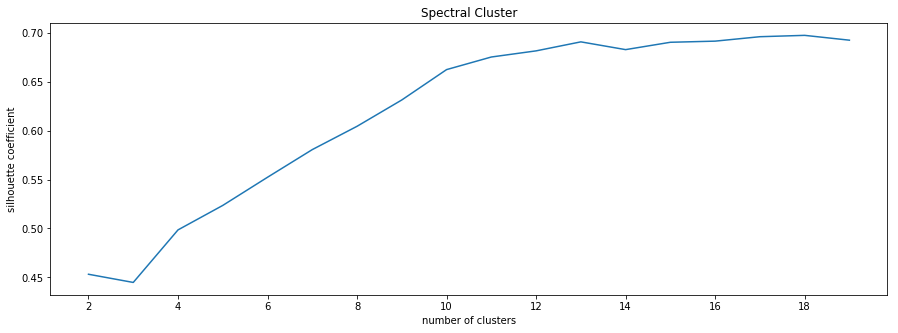

In [56]:
Sil_coefs = []
for k in range(2,20):
    sc = SpectralClustering(n_clusters = k)
    sc.fit(teaflavdf)
    labels = sc.labels_
    Sil_coefs.append(metrics.silhouette_score(teaflavdf, labels, metric='euclidean'))
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_title('Spectral Cluster')
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2))

([<matplotlib.axis.XTick at 0x1a11133a90>,
 <a list of 9 Text xticklabel objects>)

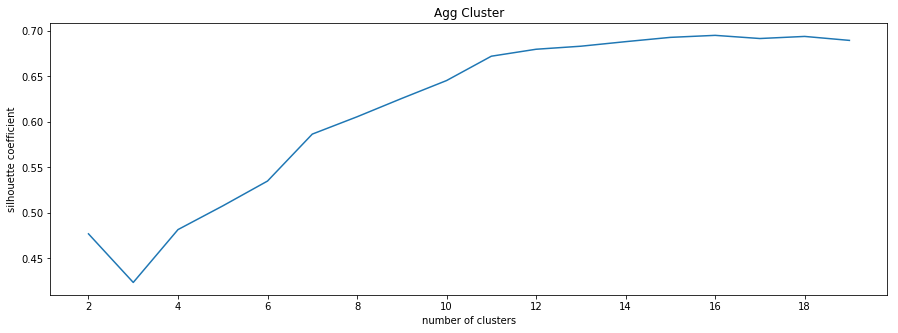

In [55]:
Sil_coefs = []
for k in range(2,20):
    ac = AgglomerativeClustering(n_clusters = k)
    ac.fit(teaflavdf)
    labels = ac.labels_
    Sil_coefs.append(metrics.silhouette_score(teaflavdf, labels, metric='euclidean'))
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_title('Agg Cluster')
plt.xticks(np.arange(2, 20, step=2))

In [52]:
Sil_coefs = []
for k in range(2,20):
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(teaflavdf)
    labels = km.labels_
    Sil_coefs.append(metrics.silhouette_score(teaflavdf, labels, metric='euclidean'))

([<matplotlib.axis.XTick at 0x1a18e090b8>,
 <a list of 9 Text xticklabel objects>)

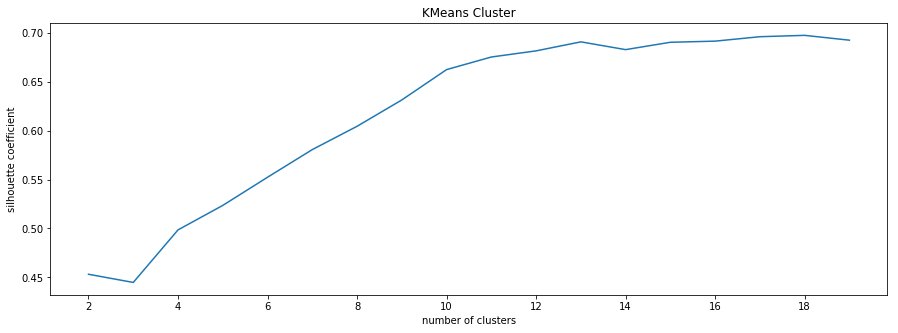

In [57]:
fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
k_clusters = range(2,20)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_title('KMeans Cluster')
ax1.set_ylabel('silhouette coefficient')
plt.xticks(np.arange(2, 20, step=2))


### Surprise

In [ ]:
teadf = teadf.set_index('Tea Name')

In [ ]:
reviewvect = vect.fit_transform(teadf[['Reviews Supertext','Tea Flavors']])
#flavvect = vect.fit_transform(teadf['Tea Flavors'])

In [ ]:
pd.DataFrame(reviewvect.toarray(), index=example, columns=vectorizer.get_feature_names()).head(10)
dtm = dtm.asfptype()

In [90]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [91]:
principalComponents = pca.fit_transform(teaflavdf)
X = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

Text(0,0.5,'PC2')

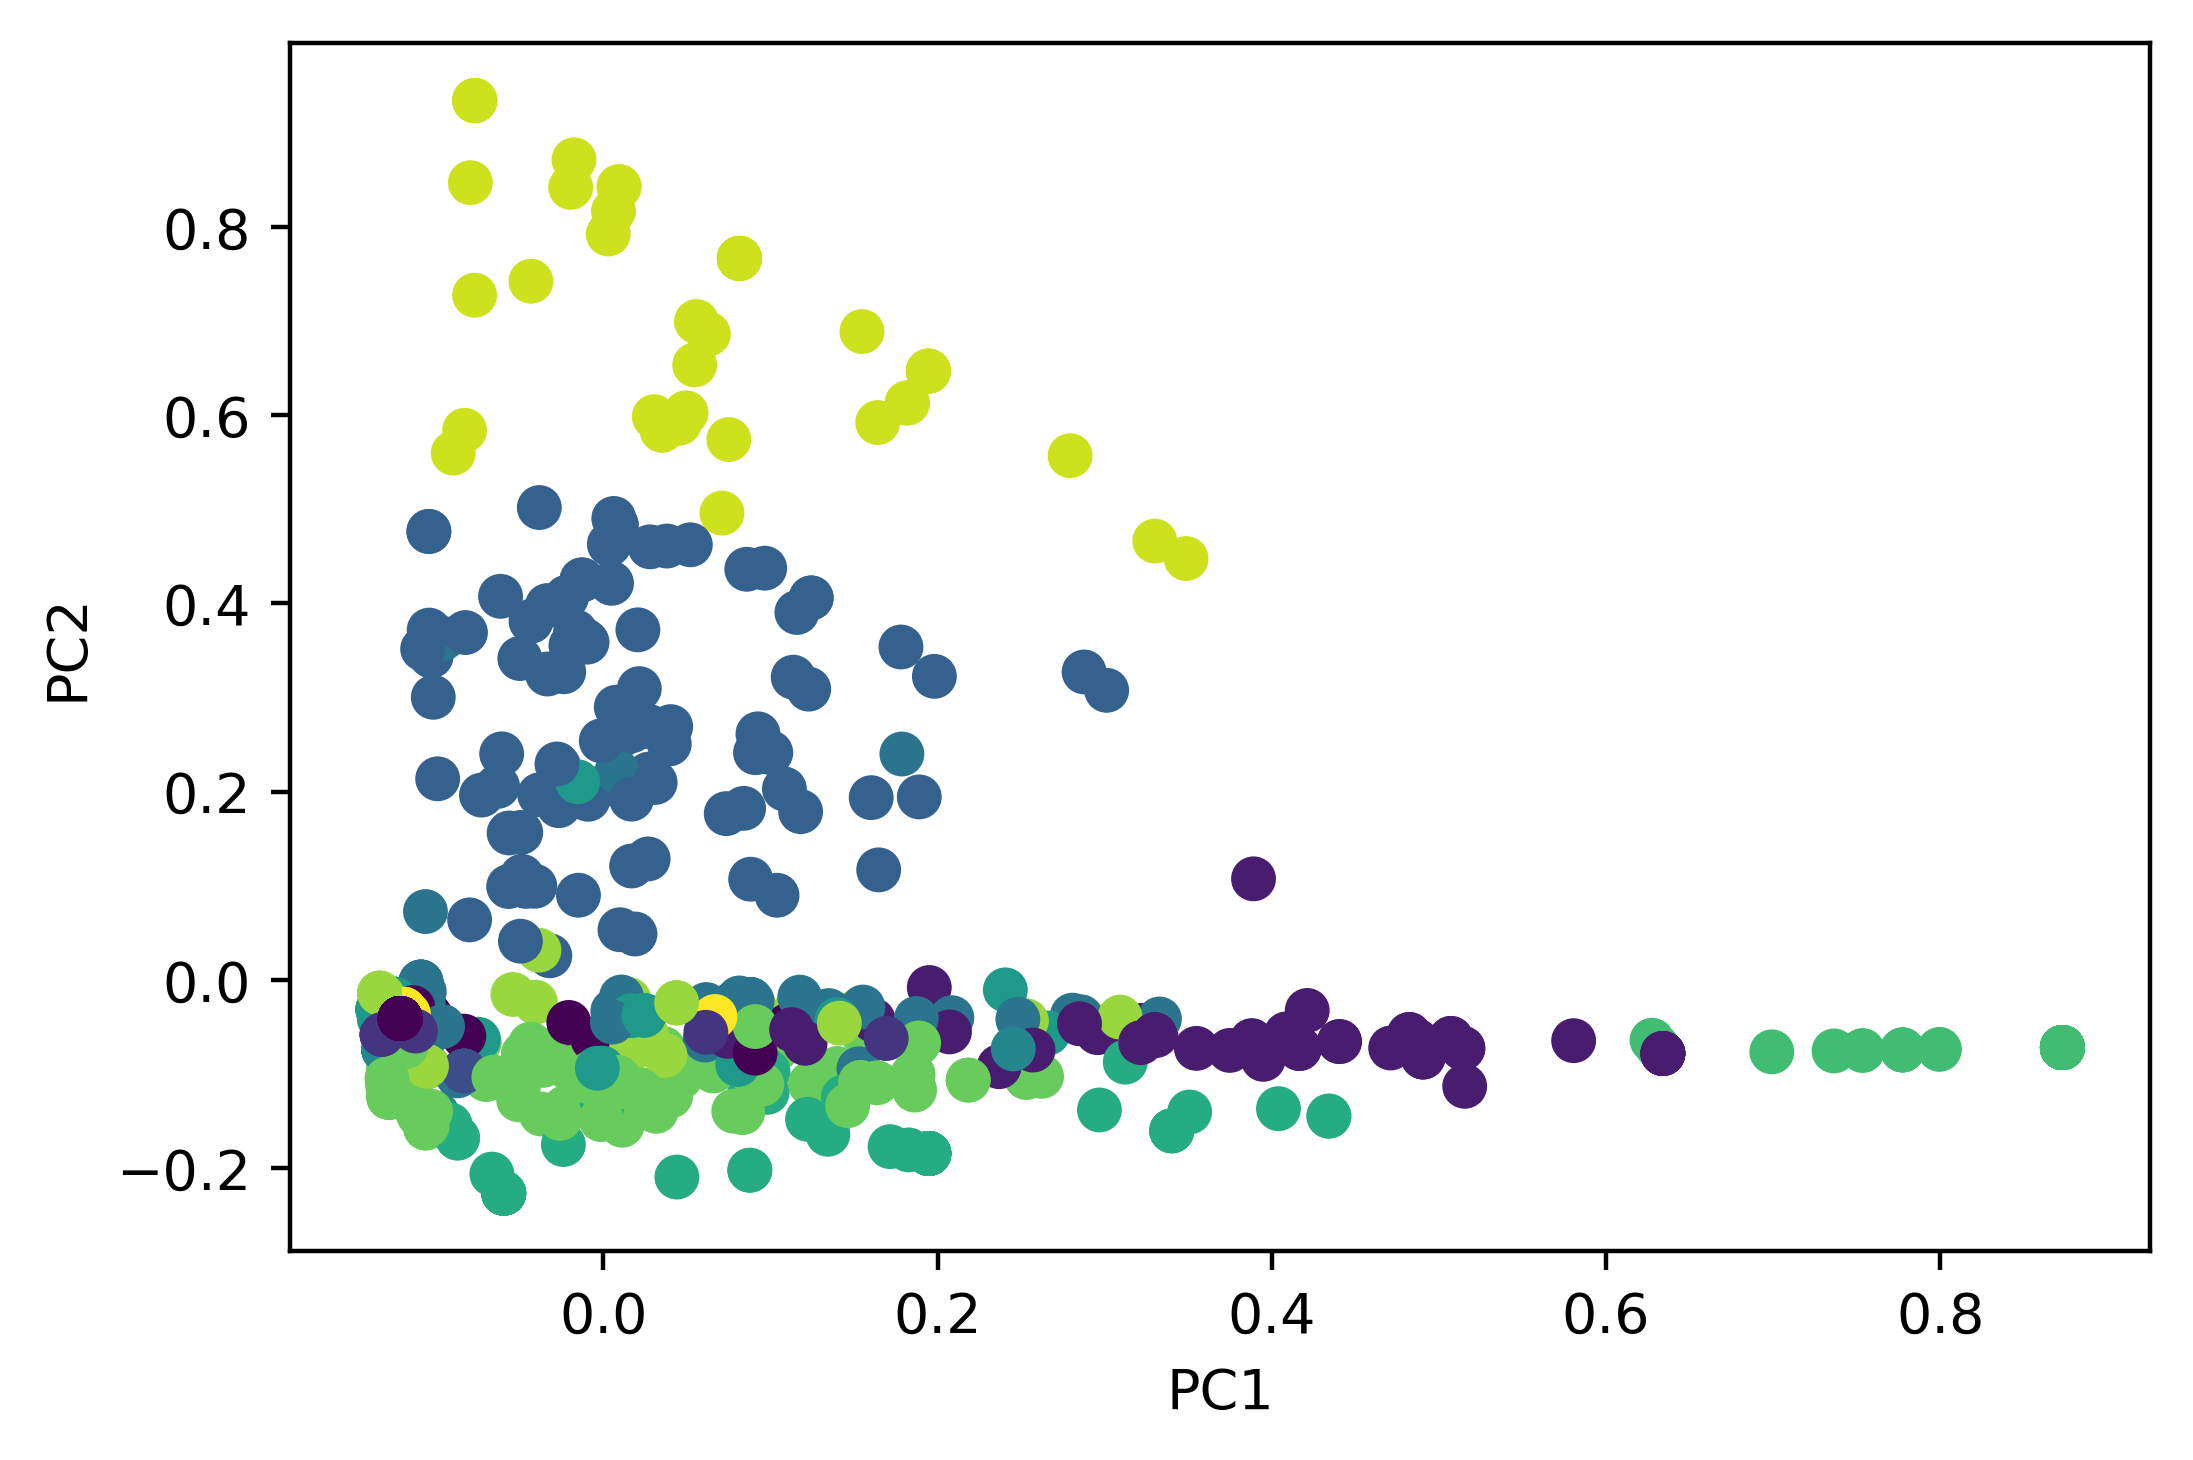

In [92]:
plt.scatter(X['principal component 1'], X['principal component 2'], c=kmlabels, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.xlabel('PC1')
plt.ylabel('PC2')

In [93]:
principalDf.columns

NameError: name 'principalDf' is not defined